<H1>접속반 단자대 온도 예측모델</H1>

 원격지에 위치한 신재생e 설비(태양광)는 최근 3년간 전기적 요인에 의해 발생한 화재에서 발화지점이 접속반인 건이 전체 비율에 48%를 차지하고 있어  
 접속반 단자대의 높은 온도 상승 및 결로 현상을 통해 접속반 내부의 스파크 발생이 화재의 원인으로 추정 되고 있다.


# 1.Data 전처리 

In [4]:
# Module Loading
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib
%matplotlib inline

# 음수 깨지지 않게
matplotlib.rcParams['axes.unicode_minus'] = False

In [5]:
warnings.filterwarnings('ignore')
# Chart에서 한글쓰기 
plt.rc('font',family='Malgun Gothic')

## 1.1 제공 데이터 확인

In [6]:
ind = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
col = [0,0,0,0,0]
con = [[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]
df = pd.DataFrame(con, columns=col, index=ind)
df.index = ["df_connectbox_day ", "df_connectbox","th_digitalmeter","th_digitalmeter_day","th_event","th_inverter","th_inverter_day","th_temp","th_temp_day","th_weather","th_weather_day"]
df.columns = ["건수","주기",'활용여부','기간','설명']
df.loc["df_connectbox_day "]=[92044,'1h','o','21/01/01/05:00~ 22/03/30/09:00','시간당 접속반의 Data']
df.loc[ "df_connectbox"]=[4227340,'1m','o','21/01/01/05:00~ 22/03/30/09:55','분당 접속반의 Data']
df.loc["th_digitalmeter"]=[1300970,'1m','x','21/01/01/05:00~ 22/03/30/09:55','분당 차단기의 Data']
df.loc["th_digitalmeter_day"]=[28766,'1h','x','21/01/01/05:00~ 22/03/30/09:00','시간당 차단기의 Data']
df.loc["th_event"]=[5463,'1m','x','21/01/01/05:00~ 22/03/30/09:55','분당 이벤트 Data']
df.loc["th_inverter"]=[878236,'1m','x','21/01/01/05:00~ 22/03/30/09:55','분당 인버터의 Data']
df.loc["th_inverter_day"]=[15133,'1h','x','21/01/01/05:00~ 22/03/30/09:00','시간당 인버터의 Data']
df.loc["th_temp"]=[845468,'1m','x','21/01/01/05:00~ 22/03/30/09:55','분당 변압기의 Data']
df.loc["th_temp_day"]=[15133,'1h','x','21/01/01/05:00~ 22/03/30/09:00','시간당 변압기의 Data']
df.loc["th_weather"]=[422734,'1m','o','21/01/01/05:00~ 22/03/30/09:55','분당 기상 Data']
df.loc["th_weather_day"]=[15133,'1h','x','21/01/01/05:00~ 22/03/30/09:00','시간당 기상 Data']

df

,건수,주기,활용여부,기간,설명
df_connectbox_day,92044,1h,o,21/01/01/05:00~ 22/03/30/09:00,시간당 접속반의 Data
df_connectbox,4227340,1m,o,21/01/01/05:00~ 22/03/30/09:55,분당 접속반의 Data
th_digitalmeter,1300970,1m,x,21/01/01/05:00~ 22/03/30/09:55,분당 차단기의 Data
th_digitalmeter_day,28766,1h,x,21/01/01/05:00~ 22/03/30/09:00,시간당 차단기의 Data
th_event,5463,1m,x,21/01/01/05:00~ 22/03/30/09:55,분당 이벤트 Data
th_inverter,878236,1m,x,21/01/01/05:00~ 22/03/30/09:55,분당 인버터의 Data
th_inverter_day,15133,1h,x,21/01/01/05:00~ 22/03/30/09:00,시간당 인버터의 Data
th_temp,845468,1m,x,21/01/01/05:00~ 22/03/30/09:55,분당 변압기의 Data
th_temp_day,15133,1h,x,21/01/01/05:00~ 22/03/30/09:00,시간당 변압기의 Data
th_weather,422734,1m,o,21/01/01/05:00~ 22/03/30/09:55,분당 기상 Data


## 1.2 대표 접속반 선정
분석 대상의 데이터를 조사결과 접속반 내의 단자대 온도를 활용한 건전성 지표 개발에 필요한 분당 접속반 데이터(th_connectbox)의 건수가 400만건 이상으로 분석에 필요한 시간과 제공 분석자원이 불필요하게 많이 소모된다.
그렇므로 10개의 접속반중 대표 접속반을 선정하기 위한 기술통계가 필요하다.
또한 단자대 온도에 영향을 미치는 요소들에 대한 상관관계를 분석이 필요하다.
기술통계를 통해 대표 접속반을 선정한 후 대표 접속반을 기준으로 현재/5/10분전 데이터로 10분후 단자대 온도 예측 모델을 구현한다.
예측 모델을 통한 10분  예측 단자대 온도에 대하여는 단측 검정값으로 건저성 판단 지표를 개발한다.

In [7]:
# 접속반 데이터 lOADING
df_connectbox = pd.read_csv('E:/data/th_connectbox.csv', encoding = 'utf-16' , sep = ',')

### 1.2.1  데이터 중복 제거
접속반 데이터의 2021년 데이터가 생성일자와 접속반 번호 기준으로 중복된 데이터가 존재하므로 중복을 제거한다.

In [8]:
# 생성일시 AND 설비번호(ITEM_NO) 기준으로 중복을 제거한다
df_connectbox = df_connectbox.drop_duplicates(['create_date', 'item_no'])
df_connectbox = df_connectbox[~(df_connectbox.create_date == 'create_date')].copy()
df_connectbox['create_date'] = pd.to_datetime(df_connectbox['create_date'], errors='coerce')

# 사용할 변수를 숫자로 치환
df_connectbox[['item_no', 'a_total', 'in_temp','v_total']] = df_connectbox[['item_no', 'a_total', 'in_temp','v_total']].apply(pd.to_numeric)

df_connectbox

,sl_id,item_no,create_date,v_total,a_total,a01,a02,a03,a04,a05,...,a23,a24,a25,a26,a27,a28,in_temp,status0,status1,status2
0,1,8,2021-01-01 05:00:00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,-0.7,0,0,0
1,1,8,2021-01-01 05:01:00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,-0.7,0,0,0
2,1,8,2021-01-01 05:02:00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,-0.7,0,0,0
3,1,8,2021-01-01 05:03:00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,-0.7,0,0,0
4,1,8,2021-01-01 05:04:00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,-0.8,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7616046,1,17,2022-03-30 09:51:00,659.90002,13.4,0.7,0.6,0.7,0.6,0.8,...,0,0,0,0,0,0,11.8,0,0,0
7616047,1,17,2022-03-30 09:52:00,657.00000,12.3,0.6,0.6,0.7,0.6,0.8,...,0,0,0,0,0,0,11.8,0,0,0
7616048,1,17,2022-03-30 09:53:00,659.79999,13.3,0.7,0.6,0.7,0.6,0.8,...,0,0,0,0,0,0,11.8,0,0,0
7616049,1,17,2022-03-30 09:54:00,657.90002,13.5,0.7,0.7,0.7,0.6,0.8,...,0,0,0,0,0,0,11.8,0,0,0


### 1.2.2 접속반 별로 분리

In [9]:
df_connectboxAA=[]

for i in range(8,18):
    df_connectboxAA.append(df_connectbox[df_connectbox['item_no'] == i])

# 15번 접속반 
df_connectboxAA[7]

,sl_id,item_no,create_date,v_total,a_total,a01,a02,a03,a04,a05,...,a23,a24,a25,a26,a27,a28,in_temp,status0,status1,status2
2372097,1,15,2021-01-01 05:00:00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
2372098,1,15,2021-01-01 05:01:00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
2372099,1,15,2021-01-01 05:02:00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
2372100,1,15,2021-01-01 05:03:00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
2372101,1,15,2021-01-01 05:04:00,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6770578,1,15,2022-03-30 09:51:00,664.50000,11.7,0.7,0.6,0.7,0.7,0.6,...,0,0,0,0,0,0,11.8,0,0,0
6770579,1,15,2022-03-30 09:52:00,660.50000,11.1,0.6,0.6,0.7,0.6,0.6,...,0,0,0,0,0,0,11.8,0,0,0
6770580,1,15,2022-03-30 09:53:00,663.59998,11.6,0.7,0.6,0.7,0.7,0.6,...,0,0,0,0,0,0,11.8,0,0,0
6770581,1,15,2022-03-30 09:54:00,666.79999,12.2,0.7,0.7,0.7,0.7,0.6,...,0,0,0,0,0,0,11.8,0,0,0


### 1.2.3 접속반별 단자대온도 분포도

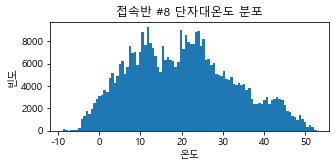

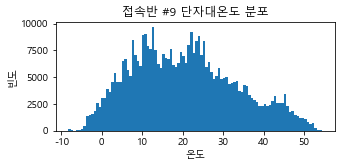

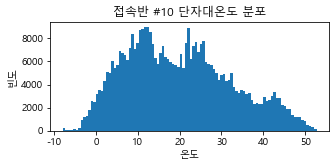

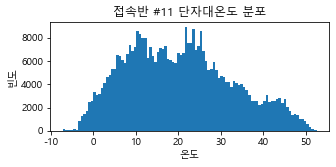

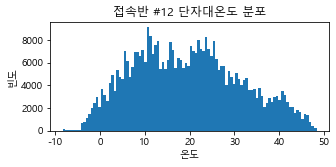

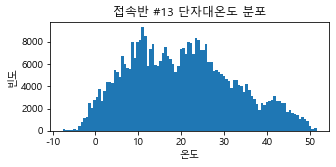

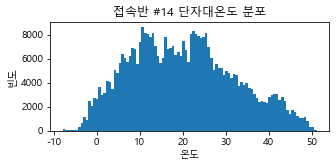

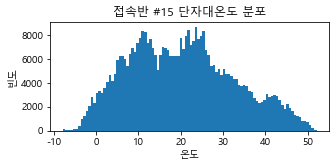

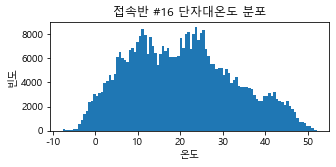

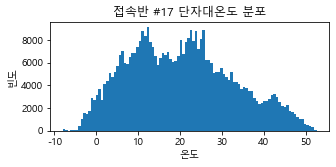

In [10]:
i=8

for cbox in df_connectboxAA:
    var_data = cbox['in_temp']
    # Create a Figure
    fig = plt.figure(figsize=(5,2))

    # Plot a histogram
    plt.hist(var_data, bins=100)

    # Add titles and labels
    plt.title('접속반 #{} 단자대온도 분포'.format(i))
    fn='C:/ConnectBox{}.pdf'.format(i)
    i+=1
    plt.xlabel('온도')
    plt.ylabel('빈도')

    # Show the figure
    fig.show()

### 1.2.4 대표 접속반 선정

In [11]:
#데이터 단자대온도 기술통계
df_connectbox_d=[]
i=8
for cBox in df_connectboxAA:
    df_connectbox_d.append(cBox.in_temp.describe())
    print(i,"-----------------\n", df_connectbox_d[i-8])
    i+=1

8 -----------------
 count    425511.000000
mean         20.241949
std          12.545701
min          -8.800000
25%          10.500000
50%          19.900000
75%          28.700001
max          52.700001
Name: in_temp, dtype: float64
9 -----------------
 count    422734.000000
mean         20.522673
std          12.838657
min          -8.300000
25%          10.500000
50%          19.700001
75%          29.200001
max          54.400002
Name: in_temp, dtype: float64
10 -----------------
 count    422734.000000
mean         19.901066
std          12.591034
min          -7.900000
25%          10.000000
50%          18.700001
75%          28.400000
max          52.700001
Name: in_temp, dtype: float64
11 -----------------
 count    422734.000000
mean         20.289464
std          12.447520
min          -7.200000
25%          10.500000
50%          19.600000
75%          28.700001
max          52.500000
Name: in_temp, dtype: float64
12 -----------------
 count    422734.000000
mean         

앞서 말했다시피 10개의 접속반 전체인 400만건이상의 Data를 가공처리하기에는 제공 분석자원과 시간을 불필요하게 많이 소모되므로 대표 접속반 선택하기로 했다.
대표접속반 선정을 위하여 각 접속반별 기술통계를 산출했다.

단자대 온도(in_temp)기준으로 기술통계값은 위와 같으며  건수, 평균, 표준편차의 전체 평균과 가장 근사한 접속반 15번을 대표 접속반은 선택한다.
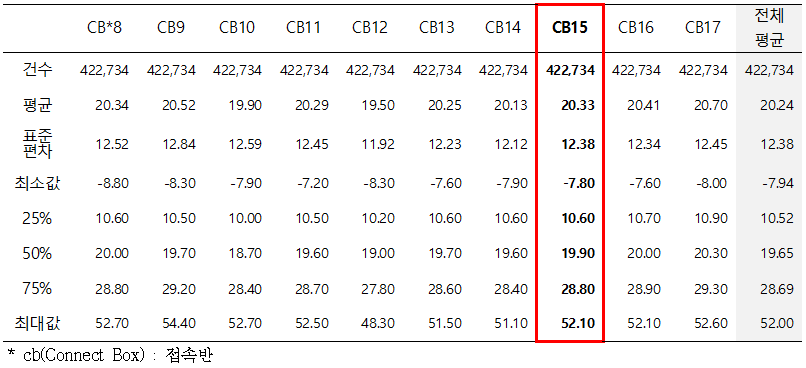

In [12]:
# 대표 접속반 15번 추출
df_connectbox15 = df_connectbox[df_connectbox['item_no'] == 15]

### 1.2.5 기상 데이터 전처리

In [13]:
# 기상 Data Loading
df_weather = pd.read_csv('E:/data/th_weather.csv', encoding = 'utf-16' , sep = ',')
df_weather = df_weather[~(df_weather.create_date == 'create_date')].copy()

In [14]:
# 접속반 데이터와 동일하게 2021년 데이터가 생성일자 기준으로 중복 제거
df_weather.create_date = pd.to_datetime(df_weather['create_date'], errors='coerce')
df_weather = df_weather.drop_duplicates(['create_date']).reset_index(drop = True)
df_weather=df_weather.sort_values(by=['create_date'])
df_weather[['out_temp']] = df_weather[['out_temp']].apply(pd.to_numeric)

In [15]:
df_weather.head()

,sl_id,item_no,create_date,s_radiation,h_radiation,mod_temp,out_temp,wind_direction,wind_speed,rainfall,humidity,ma1,ma2,out_temp2,status0,status1,status2
2111,1,18,2021-01-01 05:00:00,20.5625,0.0,1.299999,-2.299999,0,0,0,0,0,0,0,0,0,0
2112,1,18,2021-01-01 05:01:00,20.5625,0.0,1.299999,-2.299999,0,0,0,0,0,0,0,0,0,0
2113,1,18,2021-01-01 05:02:00,20.5625,0.0,1.299999,-2.400000,0,0,0,0,0,0,0,0,0,0
2114,1,18,2021-01-01 05:03:00,20.5625,0.0,1.299999,-2.299999,0,0,0,0,0,0,0,0,0,0
2115,1,18,2021-01-01 05:04:00,20.5625,0.0,1.299999,-2.299999,0,0,0,0,0,0,0,0,0,0


# 2. Data Set 생성
## 2.1 Data Set 융복합 Index 생성

In [17]:
# 융복합을 위해 생성일자를 Index로 설정 
df_weather = df_weather.set_index('create_date')
df_connectbox15 = df_connectbox15.set_index('create_date')

In [18]:
df_connectbox15

,sl_id,item_no,v_total,a_total,a01,a02,a03,a04,a05,a06,...,a23,a24,a25,a26,a27,a28,in_temp,status0,status1,status2
create_date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 05:00:00,1,15,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
2021-01-01 05:01:00,1,15,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
2021-01-01 05:02:00,1,15,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
2021-01-01 05:03:00,1,15,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
2021-01-01 05:04:00,1,15,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-30 09:51:00,1,15,664.50000,11.7,0.7,0.6,0.7,0.7,0.6,0.6,...,0,0,0,0,0,0,11.8,0,0,0
2022-03-30 09:52:00,1,15,660.50000,11.1,0.6,0.6,0.7,0.6,0.6,0.6,...,0,0,0,0,0,0,11.8,0,0,0
2022-03-30 09:53:00,1,15,663.59998,11.6,0.7,0.6,0.7,0.7,0.6,0.6,...,0,0,0,0,0,0,11.8,0,0,0


In [19]:
df_weather

,sl_id,item_no,s_radiation,h_radiation,mod_temp,out_temp,wind_direction,wind_speed,rainfall,humidity,ma1,ma2,out_temp2,status0,status1,status2
create_date,,,,,,,,,,,,,,,,
2021-01-01 05:00:00,1,18,20.5625,0.0,1.299999,-2.299999,0,0,0,0,0,0,0,0,0,0
2021-01-01 05:01:00,1,18,20.5625,0.0,1.299999,-2.299999,0,0,0,0,0,0,0,0,0,0
2021-01-01 05:02:00,1,18,20.5625,0.0,1.299999,-2.400000,0,0,0,0,0,0,0,0,0,0
2021-01-01 05:03:00,1,18,20.5625,0.0,1.299999,-2.299999,0,0,0,0,0,0,0,0,0,0
2021-01-01 05:04:00,1,18,20.5625,0.0,1.299999,-2.299999,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-30 09:51:00,1,18,66.0625,56.4375,13.200001,9.799999,0,0,0,0,0,0,0,0,0,0
2022-03-30 09:52:00,1,18,63.875,54.6875,13.200001,9.900000,0,0,0,0,0,0,0,0,0,0
2022-03-30 09:53:00,1,18,68.6875,60.375,13.299999,10.000000,0,0,0,0,0,0,0,0,0,0


## 2.2 상관계수를 통한 Feature Selection
접속반 데이터중 대표 접속반인 접속반 15번(df_15)과 기상데이터(df_weather)를 생성일시 기준으로 융합(MS Excel 활용)
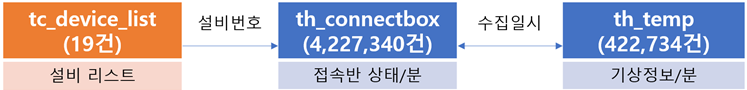
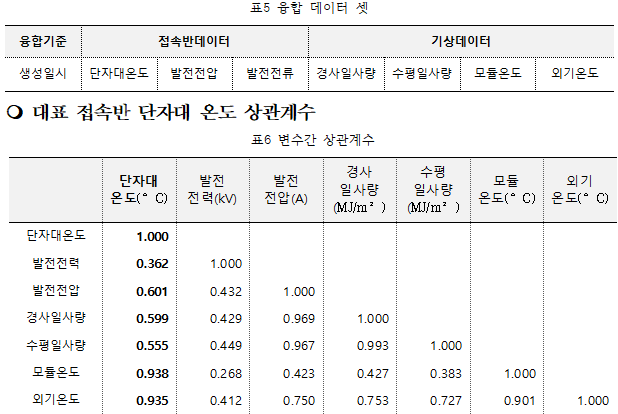

예상과 같이 <b>*단자대온도와 외기온도, 모듈온도, 발전전압*</b>순 으로 0.5이상으로 강한 양의 상관관계를 보였다.
모듈온도와 외기온도는 동일한 Feature로 판단하여 외기온도 하나만을 선택 하였다.

## 2.2 설정시간>5분>10분전 이동 데이터 생성 

설정시간을 기준으로 설정시간, 과거 5분전, 과거 10분전 이동 데이터셋 생성

### 2.2.1 설정시간 기준 이동 데이터 추출 함수 

In [20]:
# 기준시간 이동추출을 위한 Function
def my_shift_time(df, col_name, lag):
    x = df[col_name].copy()
    x.index += pd.Timedelta(minutes=lag)
    return x

### 2.2.2 설정시간 초기화

설정시간과 예측시간과의 차이를 조정함으로써 적절한 시간차를 찾아 적용해야한다
시간차가 너무 짧을 경우 설정시간과 예측시간과의 차이가 거의 없어 재대로된 예측이 불가하고 시간차가 너무 길 경우 재대로된 예측모델을 만들기 어렵다
10분부터 10분씩 증가 시키며 최적의 골든타임을 찾는다  

In [21]:
# 10~50 분
iTime = 40

### 2.2.3 분석 DataSet 생성

In [22]:
# df_weather 외기온도 배열 선언
out_temp=[]
# df_connectbox15 내부온도 배열선언
in_temp=[]
# df_connectbox15 발전전류 배열선언
a_total=[]

for min5 in [0, 5, 10]:
    out_temp.append(my_shift_time(df_weather, 'out_temp', min5+iTime))
    in_temp.append(my_shift_time(df_connectbox15, 'in_temp', min5+iTime))
    a_total.append(my_shift_time(df_connectbox15, 'a_total', min5+iTime))
    

In [23]:
out_temp[2]

create_date
2021-01-01 05:50:00    -2.299999
2021-01-01 05:51:00    -2.299999
2021-01-01 05:52:00    -2.400000
2021-01-01 05:53:00    -2.299999
2021-01-01 05:54:00    -2.299999
                         ...    
2022-03-30 10:41:00     9.799999
2022-03-30 10:42:00     9.900000
2022-03-30 10:43:00    10.000000
2022-03-30 10:44:00    10.000000
2022-03-30 10:45:00    10.100000
Name: out_temp, Length: 422734, dtype: float64

<b> 기상 데이터와 접속반(#15) 융복합 </b>

접속반 데이터중 대표 접속반인 접속반 15번(df_15)과 기상데이터(df_weather)를 생성일시 기준으로 융합

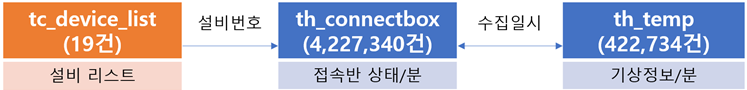
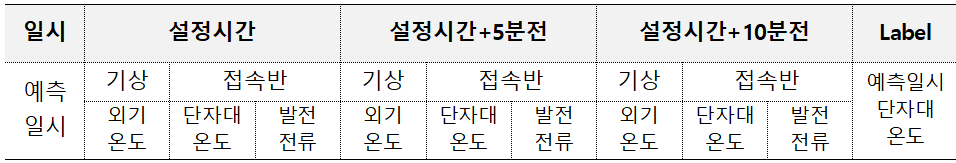

In [24]:
df15 = [ out_temp[0], in_temp[0],a_total[0],  out_temp[1], in_temp[1],a_total[1], out_temp[2], in_temp[2],a_total[2],  df_connectbox15["in_temp"]]
df_15 = reduce(lambda x, y : pd.merge(x, y, on = 'create_date'), df15)

In [25]:
df_15.columns = ["out_temp_p", "in_temp_p", "a_total_p", "out_temp_5m", "in_temp_5m", "a_total_5m", "out_temp_10m", "in_temp_10m", "a_total_10m",  "y_in_temp"]
df_15

,out_temp_p,in_temp_p,a_total_p,out_temp_5m,in_temp_5m,a_total_5m,out_temp_10m,in_temp_10m,a_total_10m,y_in_temp
create_date,,,,,,,,,,
2021-01-01 05:50:00,-2.299999,0.0,0.0,-2.299999,0.0,0.0,-2.299999,0.0,0.0,-0.1
2021-01-01 05:51:00,-2.299999,0.0,0.0,-2.299999,0.0,0.0,-2.299999,0.0,0.0,-0.1
2021-01-01 05:52:00,-2.299999,-0.1,0.0,-2.200001,0.0,0.0,-2.400000,0.0,0.0,-0.2
2021-01-01 05:53:00,-2.299999,-0.1,0.0,-2.299999,0.0,0.0,-2.299999,0.0,0.0,-0.2
2021-01-01 05:54:00,-2.299999,-0.1,0.0,-2.299999,0.0,0.0,-2.299999,0.0,0.0,-0.2
...,...,...,...,...,...,...,...,...,...,...
2022-03-30 09:50:00,9.799999,10.8,8.8,10.100000,10.7,2.4,10.200001,10.5,7.6,11.8
2022-03-30 09:51:00,9.700001,10.9,9.2,10.000000,10.7,8.0,10.200001,10.6,3.2,11.8
2022-03-30 09:53:00,9.600000,11.0,8.3,9.900000,10.8,8.7,10.100000,10.6,6.1,11.8


# 3. 분석모델 학습하기
## 3.1 교차검증(Cross Validation) 셋 분리하기

In [26]:
# Separate features and labels
X, y = df_15[["out_temp_p", "in_temp_p", "a_total_p", "out_temp_5m", "in_temp_5m", "a_total_5m", "out_temp_10m", "in_temp_10m", "a_total_10m"]].values, df_15['y_in_temp'].values
print('Features:',X[:387897], '\nLabels:', y[:387897], sep='\n')

Features:
[[-2.2999992   0.          0.         ... -2.2999992   0.
   0.        ]
 [-2.2999992   0.          0.         ... -2.2999992   0.
   0.        ]
 [-2.2999992  -0.1         0.         ... -2.3999996   0.
   0.        ]
 ...
 [ 9.6000004  11.          8.3000002  ... 10.1        10.6
   6.0999999 ]
 [ 9.6000004  11.          7.5999999  ... 10.1        10.7
   0.80000001]
 [ 9.6000004  11.          7.5999999  ... 10.1        10.7
   2.4000001 ]]

Labels:
[-0.1 -0.1 -0.2 ... 11.8 11.8 11.9]


In [27]:
df_15.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 387897 entries, 2021-01-01 05:50:00 to 2022-03-30 09:55:00
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   out_temp_p    387897 non-null  float64
 1   in_temp_p     387897 non-null  float64
 2   a_total_p     387897 non-null  float64
 3   out_temp_5m   387897 non-null  float64
 4   in_temp_5m    387897 non-null  float64
 5   a_total_5m    387897 non-null  float64
 6   out_temp_10m  387897 non-null  float64
 7   in_temp_10m   387897 non-null  float64
 8   a_total_10m   387897 non-null  float64
 9   y_in_temp     387897 non-null  float64
dtypes: float64(10)
memory usage: 32.6 MB


훈련 데이터셋(80% : 306,782건) 테스트 데이터셋(20%: 76,696건 )

In [28]:
# Split data 80%-20% into training set and test set
X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(X, y, test_size=0.20, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train_in.shape[0], X_test_in.shape[0]))


Training Set: 310317 rows
Test Set: 77580 rows


## 3.2 *LinearRegression* 학습하기

In [29]:
# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train_in, y_train_in)
print (model)

LinearRegression()


*test Data*로 확인하기

In [30]:
predictions = model.predict(X_test_in)
np.set_printoptions(suppress=True)
print('예측치 : ', np.round(predictions,1)[:10])
print('관측치 : ', np.round(y_test_in,1)[:10])

예측치 :  [46.1 26.5 24.7 24.8 18.1 31.3 26.4 29.4  9.5  0.4]
관측치 :  [43.  26.4 24.1 24.5 17.6 29.9 26.5 29.   9.2  0.5]


### 3.2.1 오차율 확인하기

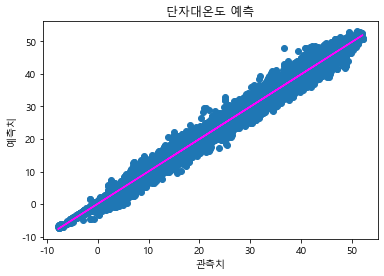

In [31]:
plt.scatter(y_test_in, predictions)
plt.xlabel('관측치')
plt.ylabel('예측치')
plt.title('단자대온도 예측')
# overlay the regression line
z = np.polyfit(y_test_in, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test_in,p(y_test_in), color='magenta')
plt.show()

### 3.2.2 통계적인 해석 & 설명
- $R^2$(R-Squared,결정계수 Coefficient of Determination) : 모형의 성능
- coef(회귀계수) : X가 한단위 증가할때 y의 변화량
- P>(t)(p-value:확률값) : 0.05(유의수준) 이하일 때 변수가 유의미함

**RMSE**와 **MSE** 값의 차이가 없는것으로 보아 결측치나 극단치(outlier)가 없는것으로 보이고 오차율이 적다.
설명력($R^2$)또한 거의 1에 근사하여 오버피팅이 의심 될정도 이다.

Mean Squared Error(평균제곱오차)
$MSE=\frac{1}{n}\sum_{i=0}^n (Y_{i}-\hat{Y}_{i})^2$

Root Mean Squared Error(제곱근 평균제곱오차)
$ RMSE= \sqrt{\frac{1}{n}\sum_{i=0}^n (Y_{i}-\hat{Y}_{i})^2}$

${n}$	=	number	of	data points, 
$Y_{i}$	=	observed values, 
$\hat{Y}_{i}$	=	predicted values

$R^2$(R-Squared)
- $R^2$는 0과 1사이에 존재
- $R^2=1$ 현재가지고 있는 X변수로 Y를 100%설명

In [32]:
mse = mean_squared_error(y_test_in, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
print("R2:", r2_score(y_test_in, predictions))
print("절편:", model.intercept_)

MSE: 1.031097911226328
RMSE: 1.0154299144826924
R2: 0.9932441239859163
절편: 1.0233406125945343


In [33]:
# statsmodels module이 없어 설치
# pip3 install statsmodels
import statsmodels.api as sm

#add constant to predictor variables
x = sm.add_constant(X_train_in)

#fit linear regression model
sm_model = sm.OLS(y_train_in, X_train_in).fit()

#view model summary
print(sm_model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.707e+07
Date:                Sat, 27 Aug 2022   Prob (F-statistic):                        0.00
Time:                        05:40:00   Log-Likelihood:                     -4.6602e+05
No. Observations:              310317   AIC:                                  9.321e+05
Df Residuals:                  310308   BIC:                                  9.322e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [34]:
cof=np.round(model.coef_,3)
print("out_temp_p  : ",cof[0],"\nout_temp_5m : ",cof[3], "\nout_temp_10m: ",cof[6], "\nin_temp_p   : ",cof[1],  
      "\nin_temp_5m  : ",cof[4],"\nin_temp_10m : ",cof[7],"\na_total_p   : ",cof[2],  "\na_total_5m  : ",cof[5],  "\na_total_10m : ",cof[8])

out_temp_p  :  0.308 
out_temp_5m :  -0.149 
out_temp_10m:  -0.016 
in_temp_p   :  3.828 
in_temp_5m  :  -1.561 
in_temp_10m :  -1.43 
a_total_p   :  0.023 
a_total_5m  :  -0.013 
a_total_10m :  -0.017


### 3.2.3 Model 검증 
외부변수(외기온도, 발전전류)값을 고정하고 단자대온도를 5도씩 증가시커 예측치 검증

In [35]:
#np.round( X_train_in[45200:45205],2)
#array([[  9.8,  13.4,  20.3,   9.6,  13.4,  14.8,   9.7,  13.4,  10.7],
#       [ 52.3,  45.5, 138.2,  52.7,  45.1, 134.2,  52.4,  44.6, 132.7],
#       [ 23.9,  18.2, 121.3,  23. ,  18. , 121.8,  23. ,  17.5, 120.5],
#       [ 19.9,  30. ,  42.3,  20.2,  30.4,  31.7,  20.3,  31.2,  35.1],
#       [ 33.6,  26.4, 148. ,  32.2,  26. , 146.3,  30.4,  25.9, 113. ]])
Xtest=[[]]
Xtest.clear()
for itemp in range(5,40,5):
    Xtest.append([33.6,  26.4+itemp, 148. ,  32.2,  26.+itemp , 146.3,  30.4,  25.9+itemp, 113.])
    Xtest.append([ 9.8,  13.4+itemp,  20.3,   9.6,  13.4+itemp,  14.8,   9.7,  13.4+itemp,  10.7])
    Xtest.append([52.3,  45.5+itemp, 138.2,  52.7,  45.1+itemp, 134.2,  52.4,  44.6+itemp, 132.7])
    Xtest.append([19.9,  30.+itemp ,  42.3,  20.2,  30.4+itemp,  31.7,  20.3,  31.2+itemp,  35.1])
    Xtest.append([ 23.9,  18.2+itemp, 121.3,  23. ,  18.+itemp , 121.8,  23. ,  17.5+itemp, 120.5])
    
print("My Test Data Set \n",np.round(Xtest,2))
predictions = model.predict(Xtest)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions))

My Test Data Set 
 [[ 33.6  31.4 148.   32.2  31.  146.3  30.4  30.9 113. ]
 [  9.8  18.4  20.3   9.6  18.4  14.8   9.7  18.4  10.7]
 [ 52.3  50.5 138.2  52.7  50.1 134.2  52.4  49.6 132.7]
 [ 19.9  35.   42.3  20.2  35.4  31.7  20.3  36.2  35.1]
 [ 23.9  23.2 121.3  23.   23.  121.8  23.   22.5 120.5]
 [ 33.6  36.4 148.   32.2  36.  146.3  30.4  35.9 113. ]
 [  9.8  23.4  20.3   9.6  23.4  14.8   9.7  23.4  10.7]
 [ 52.3  55.5 138.2  52.7  55.1 134.2  52.4  54.6 132.7]
 [ 19.9  40.   42.3  20.2  40.4  31.7  20.3  41.2  35.1]
 [ 23.9  28.2 121.3  23.   28.  121.8  23.   27.5 120.5]
 [ 33.6  41.4 148.   32.2  41.  146.3  30.4  40.9 113. ]
 [  9.8  28.4  20.3   9.6  28.4  14.8   9.7  28.4  10.7]
 [ 52.3  60.5 138.2  52.7  60.1 134.2  52.4  59.6 132.7]
 [ 19.9  45.   42.3  20.2  45.4  31.7  20.3  46.2  35.1]
 [ 23.9  33.2 121.3  23.   33.  121.8  23.   32.5 120.5]
 [ 33.6  46.4 148.   32.2  46.  146.3  30.4  45.9 113. ]
 [  9.8  33.4  20.3   9.6  33.4  14.8   9.7  33.4  10.7]
 [ 52.3  65.

In [36]:
nXtest=np.round(Xtest,2)

print("현재온도 ",nXtest[::,1])
print('예측온도 ',np.round(predictions))

현재온도  [31.4 18.4 50.5 35.  23.2 36.4 23.4 55.5 40.  28.2 41.4 28.4 60.5 45.
 33.2 46.4 33.4 65.5 50.  38.2 51.4 38.4 70.5 55.  43.2 56.4 43.4 75.5
 60.  48.2 61.4 48.4 80.5 65.  53.2]
예측온도  [33. 18. 52. 31. 24. 37. 22. 56. 35. 29. 42. 26. 60. 39. 33. 46. 30. 64.
 43. 37. 50. 35. 68. 47. 41. 54. 39. 73. 52. 45. 58. 43. 77. 56. 50.]


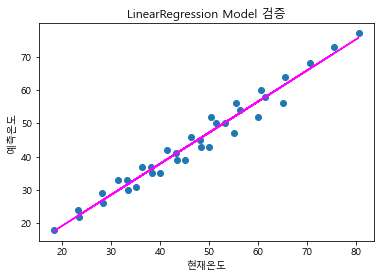

In [37]:
np.round(predictions)

plt.scatter(nXtest[::,1], np.round(predictions))
plt.xlabel('현재온도')
plt.ylabel('예측온도')
plt.title('LinearRegression Model 검증')
# overlay the regression line
z = np.polyfit(nXtest[::,1], np.round(predictions), 1)
p = np.poly1d(z)
plt.plot(nXtest[::,1],p(nXtest[::,1]), color='magenta')
plt.show()

## 3.3 RandomForest 학습하기

In [38]:
%%html
<marquee style='width:50%; color: green;'><B>ATM Fighting!!!!! GoGO RF!!!! Hurry UP Azure!!!!</B></marquee>

In [39]:
model_r = RandomForestRegressor().fit(X_train_in, y_train_in)
print (model_r, "\n")

RandomForestRegressor() 



*test Data*로 확인하기

In [40]:
predictions_r = model_r.predict(X_test_in)
np.set_printoptions(suppress=True)
print('예측치 : ', np.round(predictions_r,1)[:10])
print('관측치 : ', np.round(y_test_in,1)[:10])

예측치 :  [45.  26.3 24.3 24.5 17.7 29.9 26.6 29.2  9.3  0.5]
관측치 :  [43.  26.4 24.1 24.5 17.6 29.9 26.5 29.   9.2  0.5]


### 3.3.1 오차율 확인하기

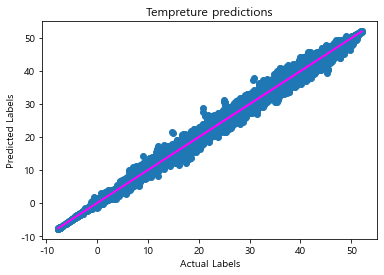

In [41]:
plt.scatter(y_test_in, predictions_r)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Tempreture predictions')
# overlay the regression line
z = np.polyfit(y_test_in, predictions_r, 1)
p = np.poly1d(z)
plt.plot(y_test_in,p(y_test_in), color='magenta')
plt.show()

In [42]:
mse = mean_squared_error(y_test_in, predictions_r)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
print("R2:", r2_score(y_test_in, predictions_r))


MSE: 0.3008929120304134
RMSE: 0.5485370653204881
R2: 0.998028513892753


### 3.3.2  Model 검증
외부변수(외기온도, 발전전류)값을 고정하고 단자대온도를 5도씩 증가시커 예측치 검증

In [43]:
#np.round( X_train_in[45200:45205],2)
#array([[  9.8,  13.4,  20.3,   9.6,  13.4,  14.8,   9.7,  13.4,  10.7],
#       [ 52.3,  45.5, 138.2,  52.7,  45.1, 134.2,  52.4,  44.6, 132.7],
#       [ 23.9,  18.2, 121.3,  23. ,  18. , 121.8,  23. ,  17.5, 120.5],
#       [ 19.9,  30. ,  42.3,  20.2,  30.4,  31.7,  20.3,  31.2,  35.1],
#       [ 33.6,  26.4, 148. ,  32.2,  26. , 146.3,  30.4,  25.9, 113. ]])
Xtest=[[]]
Xtest.clear()
for itemp in range(5,40,5):
    Xtest.append([33.6,  26.4+itemp, 148. ,  32.2,  26.+itemp , 146.3,  30.4,  25.9+itemp, 113.])
    Xtest.append([ 9.8,  13.4+itemp,  20.3,   9.6,  13.4+itemp,  14.8,   9.7,  13.4+itemp,  10.7])
    Xtest.append([52.3,  45.5+itemp, 138.2,  52.7,  45.1+itemp, 134.2,  52.4,  44.6+itemp, 132.7])
    Xtest.append([19.9,  30.+itemp ,  42.3,  20.2,  30.4+itemp,  31.7,  20.3,  31.2+itemp,  35.1])
    Xtest.append([ 23.9,  18.2+itemp, 121.3,  23. ,  18.+itemp , 121.8,  23. ,  17.5+itemp, 120.5])
    
print("My Test Data Set \n",np.round(Xtest,2))
predictions_r = model_r.predict(Xtest)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions_r))

My Test Data Set 
 [[ 33.6  31.4 148.   32.2  31.  146.3  30.4  30.9 113. ]
 [  9.8  18.4  20.3   9.6  18.4  14.8   9.7  18.4  10.7]
 [ 52.3  50.5 138.2  52.7  50.1 134.2  52.4  49.6 132.7]
 [ 19.9  35.   42.3  20.2  35.4  31.7  20.3  36.2  35.1]
 [ 23.9  23.2 121.3  23.   23.  121.8  23.   22.5 120.5]
 [ 33.6  36.4 148.   32.2  36.  146.3  30.4  35.9 113. ]
 [  9.8  23.4  20.3   9.6  23.4  14.8   9.7  23.4  10.7]
 [ 52.3  55.5 138.2  52.7  55.1 134.2  52.4  54.6 132.7]
 [ 19.9  40.   42.3  20.2  40.4  31.7  20.3  41.2  35.1]
 [ 23.9  28.2 121.3  23.   28.  121.8  23.   27.5 120.5]
 [ 33.6  41.4 148.   32.2  41.  146.3  30.4  40.9 113. ]
 [  9.8  28.4  20.3   9.6  28.4  14.8   9.7  28.4  10.7]
 [ 52.3  60.5 138.2  52.7  60.1 134.2  52.4  59.6 132.7]
 [ 19.9  45.   42.3  20.2  45.4  31.7  20.3  46.2  35.1]
 [ 23.9  33.2 121.3  23.   33.  121.8  23.   32.5 120.5]
 [ 33.6  46.4 148.   32.2  46.  146.3  30.4  45.9 113. ]
 [  9.8  33.4  20.3   9.6  33.4  14.8   9.7  33.4  10.7]
 [ 52.3  65.

In [44]:
nXtest=np.round(Xtest,2)

print("현재온도 ",nXtest[::,1])
print('예측온도 ',np.round(predictions_r))

현재온도  [31.4 18.4 50.5 35.  23.2 36.4 23.4 55.5 40.  28.2 41.4 28.4 60.5 45.
 33.2 46.4 33.4 65.5 50.  38.2 51.4 38.4 70.5 55.  43.2 56.4 43.4 75.5
 60.  48.2 61.4 48.4 80.5 65.  53.2]
예측온도  [32. 16. 51. 31. 25. 38. 19. 51. 36. 28. 38. 23. 51. 41. 32. 45. 28. 51.
 47. 36. 52. 34. 51. 48. 41. 51. 39. 51. 48. 47. 51. 43. 51. 48. 51.]


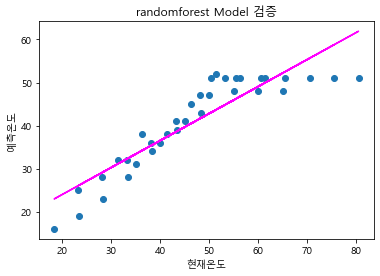

In [45]:
plt.scatter(nXtest[::,1], np.round(predictions_r))
plt.xlabel('현재온도')
plt.ylabel('예측온도')
plt.title('randomforest Model 검증')
# overlay the regression line
z = np.polyfit(nXtest[::,1], np.round(predictions_r), 1)
p = np.poly1d(z)
plt.plot(nXtest[::,1],p(nXtest[::,1]), color='magenta')
plt.show()

## 3.4  결과

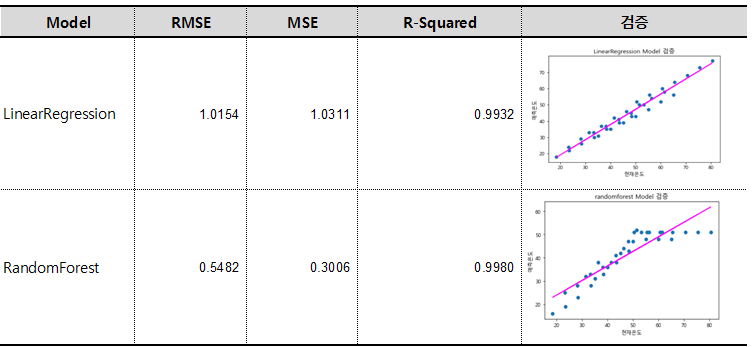

- 오차율이나$R^2$ 값이 RandomForest Model이 우수하였으나 학습되지 않은 예외의 값을 예측해야하는 경우에는 검증과정을 통해서 활용이 어렵다는 결론에 도달하여 **건전성 지표 예측**을 위한 분석 모델은 **선형회귀모델**을 선택하였다

# 4.접속반 건정성 지표

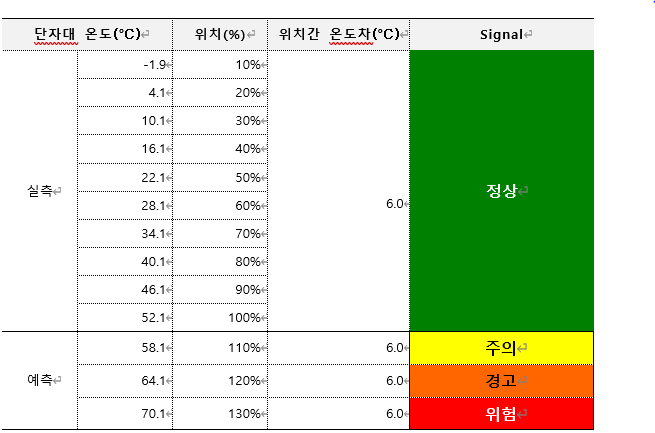

- 실측 단자대 온도중 최대 온도를 52.1°C를 정상 작동한 최대 온도를 기준을 정상 작동 온도의 100%로 설정한다.
- 실측 단자대 온도 10% 위치별 온도 통계치 결과 6°C의 등간격을 유지하고 있고 최대치인 52.1°C에서 정상 동작한바 이를 최소의 기준으로 10%씩(6°C) 증가시켜 110%(노랑 주의), 120%(주황 주의), 130%(빨강 주의) 판단 지표를 설정한다.

## 4.1 건정성 지표의 시각화

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img

img_test1 = img.imread('E:/signal/Green.png')
img_test2 = img.imread('E:/signal/Yellow.png')
img_test3 = img.imread('E:/signal/Orange.png')
img_test4 = img.imread('E:/signal/Red.png')
img_a = [img_test1,img_test2,img_test3,img_test4]

y_1 = 58.1
y_2 = 64.1
y_3 = 70.1

온도를 예측할 임의의 변수값을 입력한다.

In [ ]:
# TestDataSet 입력
pOutTemp=input("  현재 외기 온도(ex : 12.9)  : ")
pOutTemp=float(pOutTemp)
pCtemp=input("  현재 단자대온도(ex : 23.1) : ")
pCtemp=float(pCtemp)
pGenA=input("  현재 발전 전류(ex : 0.4)   : ")
pGenA=float(pGenA)

pOutTemp5=input(" 5분전 외기 온도(ex : 12.9)  : ")
pOutTemp5=float(pOutTemp5)
pCtemp5=input(" 5분전 단자대온도(ex : 23.1) : ")
pCtemp5=float(pCtemp5)
pGenA5=input(" 5분전 발전 전류(ex : 0.4)   : ")
pGenA5=float(pGenA5)

pOutTemp10=input("10분전 외기 온도(ex : 12.9)  : ")
pOutTemp10=float(pOutTemp10)
pCtemp10=input("10분전 단자대온도(ex : 23.1) : ")
pCtemp10=float(pCtemp10)
pGenA10=input("10분전 발전 전류(ex : 0.4)   : ")
pGenA10=float(pGenA10)

my_test_1=[[pOutTemp, pCtemp, pGenA, pOutTemp5, pCtemp5, pGenA5, pOutTemp10, pCtemp10, pGenA10]]
print("Input Test Data Set : ",my_test_1)

# LinearRegression Prediction
predictions_L = model.predict(my_test_1)
print('LinearRegression Model ',iTime,'분후 단자대 예측온도: ', predictions_L)

x_L = predictions_L

if x_L <= y_1: # 정상
    plt.imshow(img_a[0])
elif x_L > y_1 and x_L <=y_2: # 주의
    plt.imshow(img_a[1])
elif x_L > y_2 and x_L <=y_3: # 경고
    plt.imshow(img_a[2])
elif x_L > y_3 : # 위험
    plt.imshow(img_a[3])
plt.show()
